In [ ]:
import zipfile, os, shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory('cifake/train',
                                              target_size=(32, 32),
                                              batch_size=32,
                                              class_mode='categorical')

validation_generator = datagen.flow_from_directory('cifake/valid',
                                                   target_size=(32, 32),
                                                   batch_size=32,
                                                   class_mode='categorical')

Found 10000 images belonging to 2 classes.
Found 5002 images belonging to 2 classes.


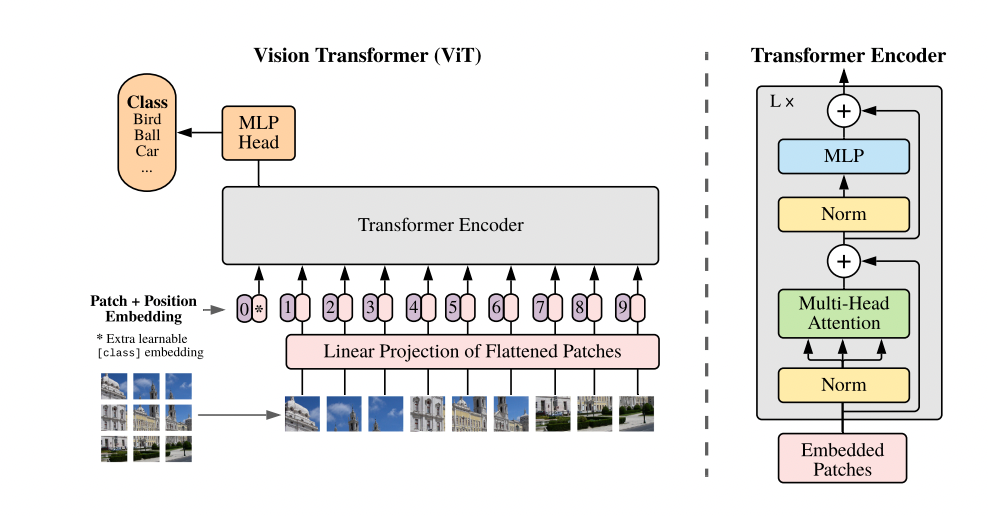

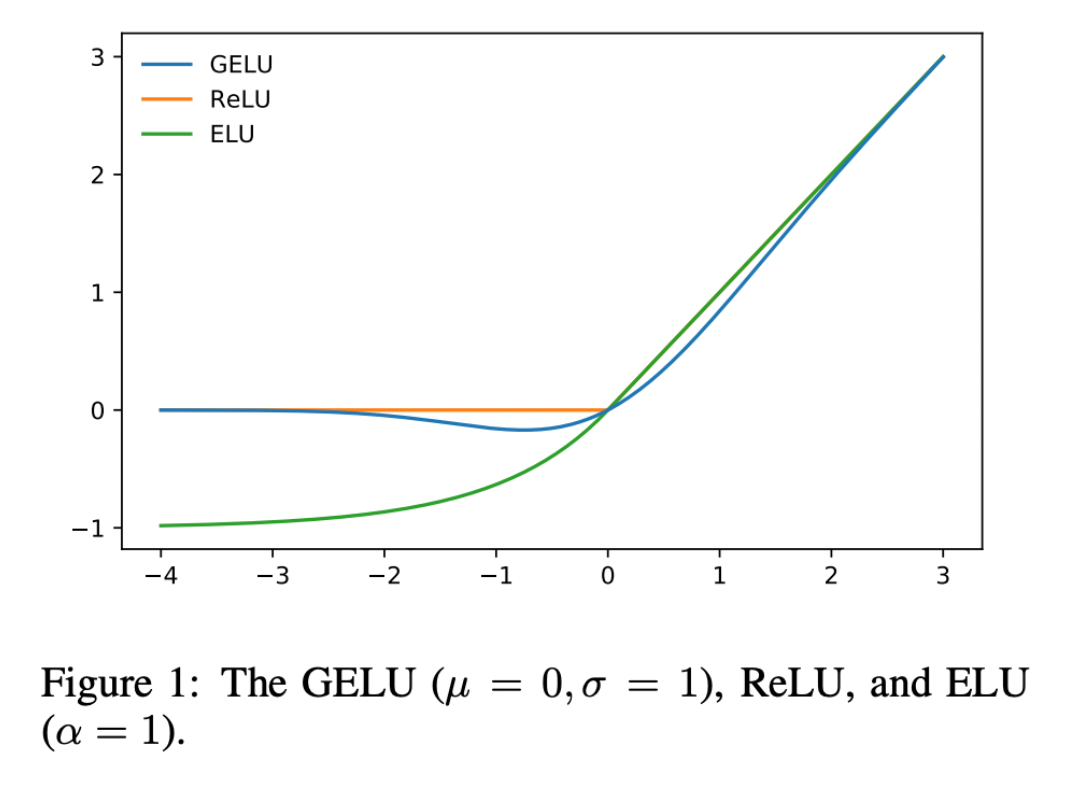

In [ ]:
def create_patches(inputs, patch_size):
    patches = tf.image.extract_patches(images=inputs,
                                       sizes=[1, patch_size, patch_size, 1],
                                       strides=[1, patch_size, patch_size, 1],
                                       rates=[1, 1, 1, 1],
                                       padding='VALID')
    patch_dim = patches.shape[-1]
    patches = tf.reshape(patches, [tf.shape(inputs)[0], -1, patch_dim])
    return patches

def patch_embedding(patches, embed_dim):
    projection = layers.Dense(embed_dim)
    embeddings = projection(patches)
    return embeddings

def add_classification_token(embeddings, embed_dim):
    batch_size = tf.shape(embeddings)[0]
    cls_token = tf.zeros((batch_size, 1, embed_dim))
    embeddings = tf.concat([cls_token, embeddings], axis=1)
    return embeddings 

def positional_embedding(sequence_length, embed_dim):
    positions = tf.range(sequence_length + 1)
    projection = layers.Embedding(sequence_length + 1, embed_dim)
    position = projection(positions)
    return position

def transformer_block(embed_dim, num_heads, sequence_length):
    inputs = keras.Input(shape=(sequence_length + 1, embed_dim))
    x1 = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x2 = layers.MultiHeadAttention(num_heads, embed_dim)(x1, x1)
    x2 = layers.Dropout(0.2)(x2)
    x3 = layers.LayerNormalization(epsilon=1e-6)(inputs + x2)
    x4 = layers.Dense(embed_dim, activation='gelu')(x3)
    x4 = layers.Dropout(0.2)(x4)
    x5 = layers.Dense(embed_dim)(x4)
    outputs = layers.LayerNormalization(epsilon=1e-6)(x3 + x5)
    return keras.Model(inputs=inputs, outputs=outputs)

def vision_transformer(image_size, patch_size, embed_dim, num_heads, sequence_length):
    inputs = keras.Input(shape=(image_size, image_size, 3))
    patches = create_patches(inputs, patch_size)
    embeddings = patch_embedding(patches, embed_dim)
    embeddings = add_classification_token(embeddings, embed_dim)
    embeddings += positional_embedding(sequence_length, embed_dim)
    for i in range(4):
        transformer = transformer_block(embed_dim, num_heads, sequence_length)
        embeddings = transformer(embeddings)
    cls_token = embeddings[:, 0]
    outputs = layers.Dense(2, activation='softmax')(cls_token)
    return keras.Model(inputs=inputs, outputs=outputs)

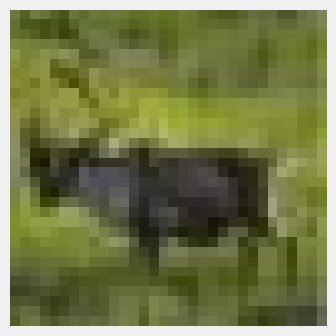

<Figure size 400x400 with 0 Axes>

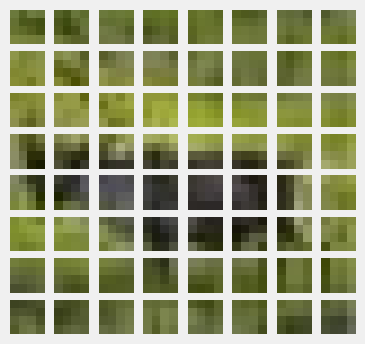

In [ ]:
images, labels = next(train_generator)

for i, input_image in enumerate(images[:1]):
    patches = create_patches(tf.expand_dims(input_image, 0), 4)

    reshaped_patches = tf.reshape(patches, [tf.shape(patches)[0], 8, 8, 4, 4, 3])

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(input_image)
    plt.axis('off')

    plt.figure(figsize=(4, 4))
    fig, axs = plt.subplots(8, 8, figsize=(4, 4))
    for j in range(8):
        for k in range(8):
            patch = reshaped_patches[i, j, k]
            axs[j, k].imshow(patch)
            axs[j, k].axis('off')

    plt.show()


In [ ]:
class F1_score(tf.keras.metrics.Metric):

    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

In [ ]:
param_grid = [{'patch_size': 2, 'embed_dim': 128, 'num_heads': 8, 'sequence_length': 256},
              {'patch_size': 2, 'embed_dim': 128, 'num_heads': 12, 'sequence_length': 256},
              {'patch_size': 4, 'embed_dim': 128, 'num_heads': 8, 'sequence_length': 64},
              {'patch_size': 4, 'embed_dim': 128, 'num_heads': 12, 'sequence_length': 64}]
models = []
for params in param_grid:
    model = vision_transformer(image_size=32, **params)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', F1_score()])
    models.append(model)

In [ ]:
history = []
for i, model in enumerate(models):
    print("Training model %d" %(i+1))
    hist = model.fit(train_generator,
                     steps_per_epoch=312,
                     epochs=20,
                     validation_data=validation_generator,
                     validation_steps=156)
    history.append(hist)

Training model 1
Epoch 1/20
312/312 [==============================] - 59s 175ms/step - loss: 0.6795 - accuracy: 0.6017 - f1_score: 0.6017 - val_loss: 0.5316 - val_accuracy: 0.7324 - val_f1_score: 0.7324
Epoch 2/20
312/312 [==============================] - 53s 170ms/step - loss: 0.5305 - accuracy: 0.7382 - f1_score: 0.7382 - val_loss: 0.4840 - val_accuracy: 0.7638 - val_f1_score: 0.7638
Epoch 3/20
312/312 [==============================] - 53s 170ms/step - loss: 0.4846 - accuracy: 0.7647 - f1_score: 0.7647 - val_loss: 0.4967 - val_accuracy: 0.7644 - val_f1_score: 0.7644
Epoch 4/20
312/312 [==============================] - 53s 169ms/step - loss: 0.4532 - accuracy: 0.7883 - f1_score: 0.7883 - val_loss: 0.4271 - val_accuracy: 0.8011 - val_f1_score: 0.8011
Epoch 5/20
312/312 [==============================] - 53s 169ms/step - loss: 0.4247 - accuracy: 0.8053 - f1_score: 0.8053 - val_loss: 0.4188 - val_accuracy: 0.8091 - val_f1_score: 0.8091
Epoch 6/20
312/312 [============================

In [ ]:
def tr_plot(tr_data):
    start_epoch=0
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    tf1=tr_data.history['f1_score']
    vf1=tr_data.history['val_f1_score']    
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    indexf1=np.argmax(vf1)
    vf1_highest=vf1[indexf1]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch) 
    f1_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=3, figsize=(25,10))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')    
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    axes[2].plot (Epochs,tf1,'r',label= 'Training F1 score')    
    axes[2].plot (Epochs,vf1,'g',label= 'Validation F1 score')
    index_tf1=np.argmax(tf1)
    tf1max=tf1[index_tf1]
    index_vf1=np.argmax(vf1)
    vf1max=vf1[index_vf1]
    axes[2].scatter(index_vf1+1 +start_epoch,vf1max, s=150, c= 'blue', label=vc_label)    
    axes[2].scatter(Epochs, tf1, s=100, c='red')
    axes[2].set_title('Training and Validation F1 score')
    axes[2].set_xlabel('Epochs', fontsize=18)
    axes[2].set_ylabel('F1  score', fontsize=18)
    axes[2].legend()    
    plt.tight_layout    
    plt.show()
    return 

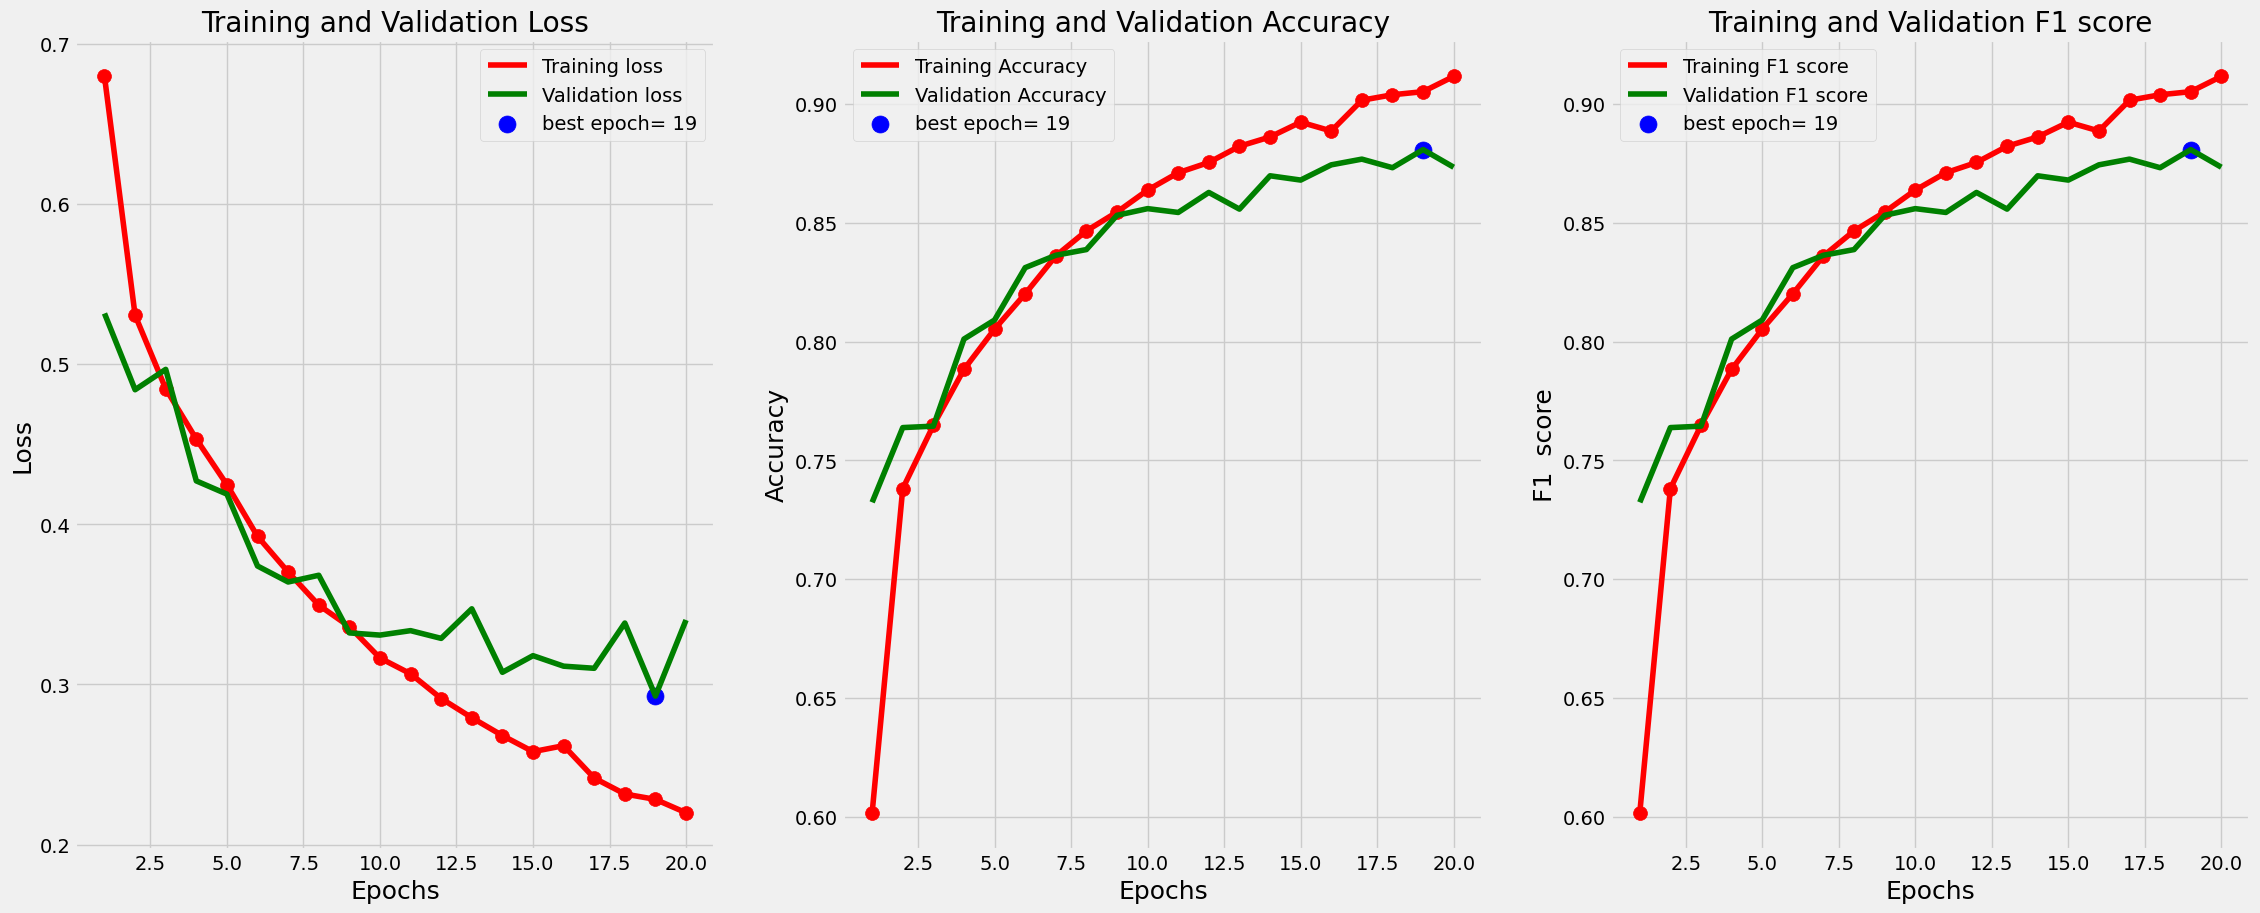

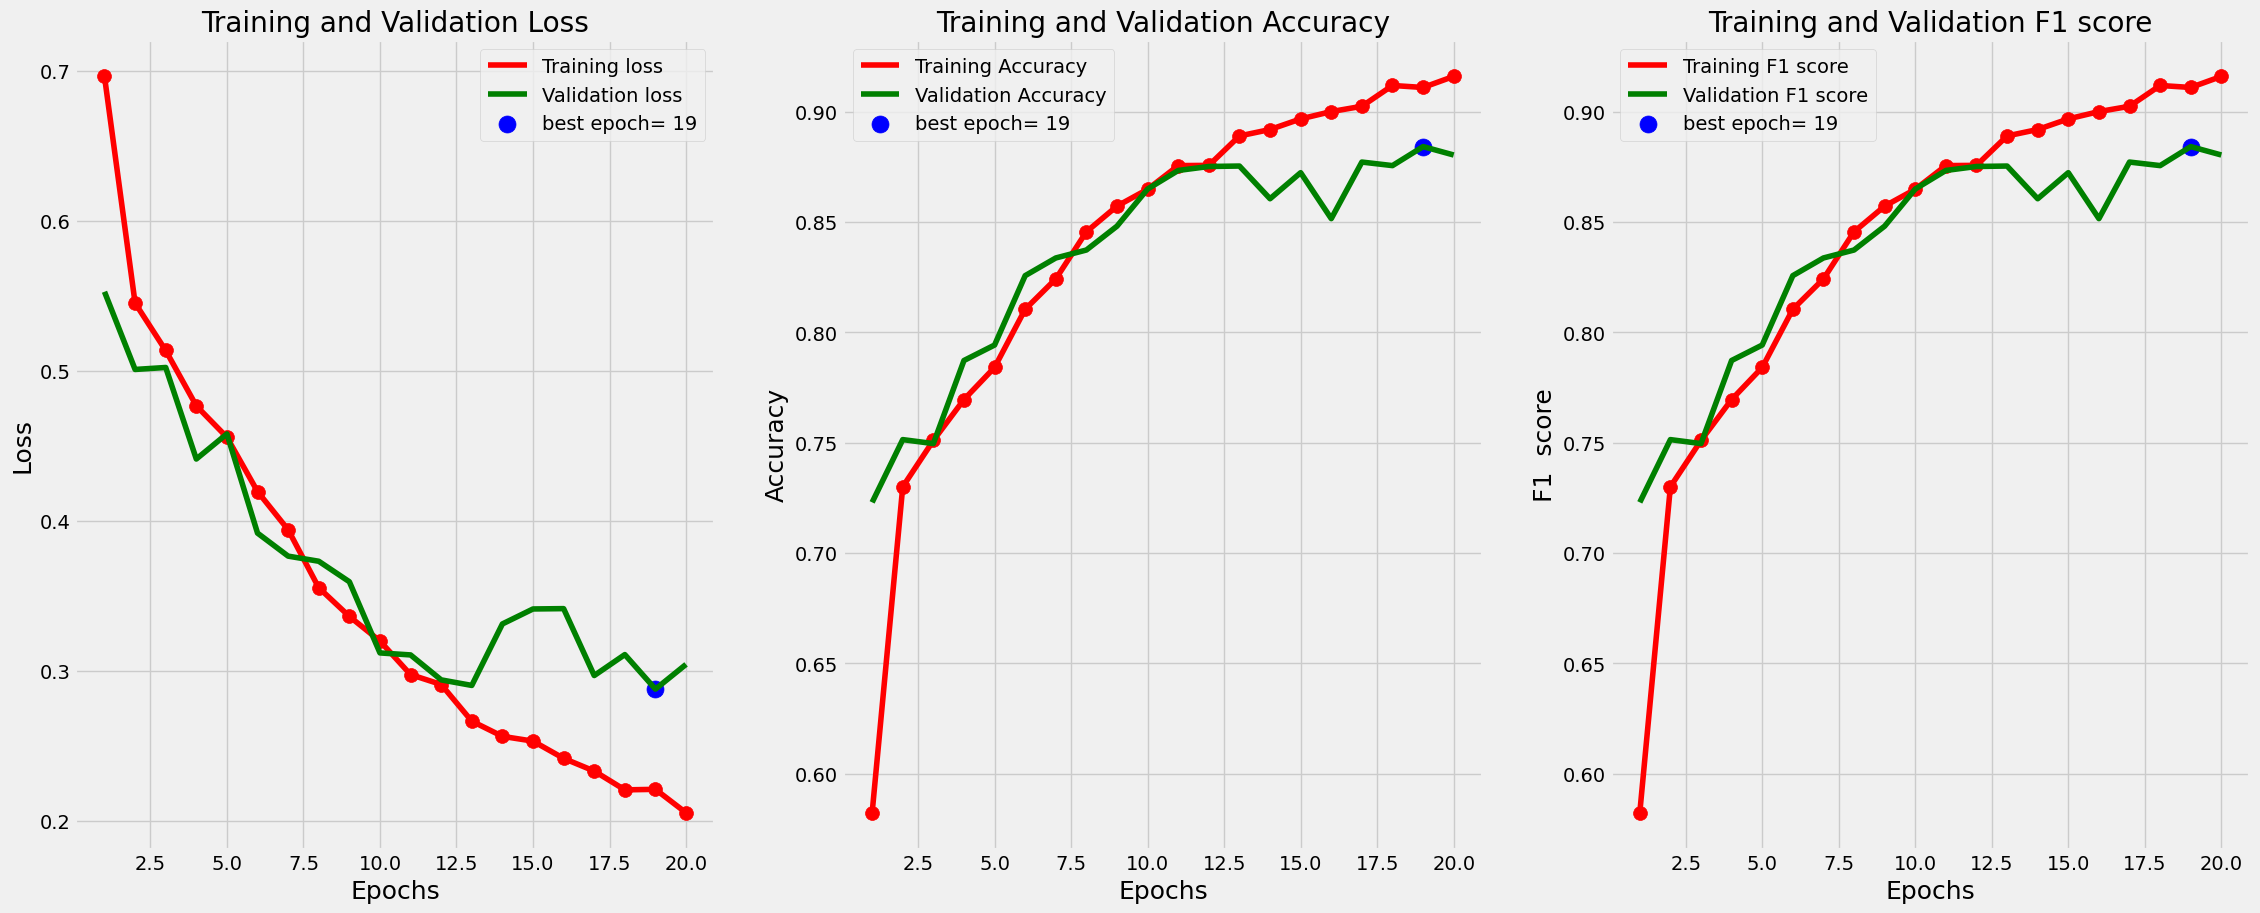

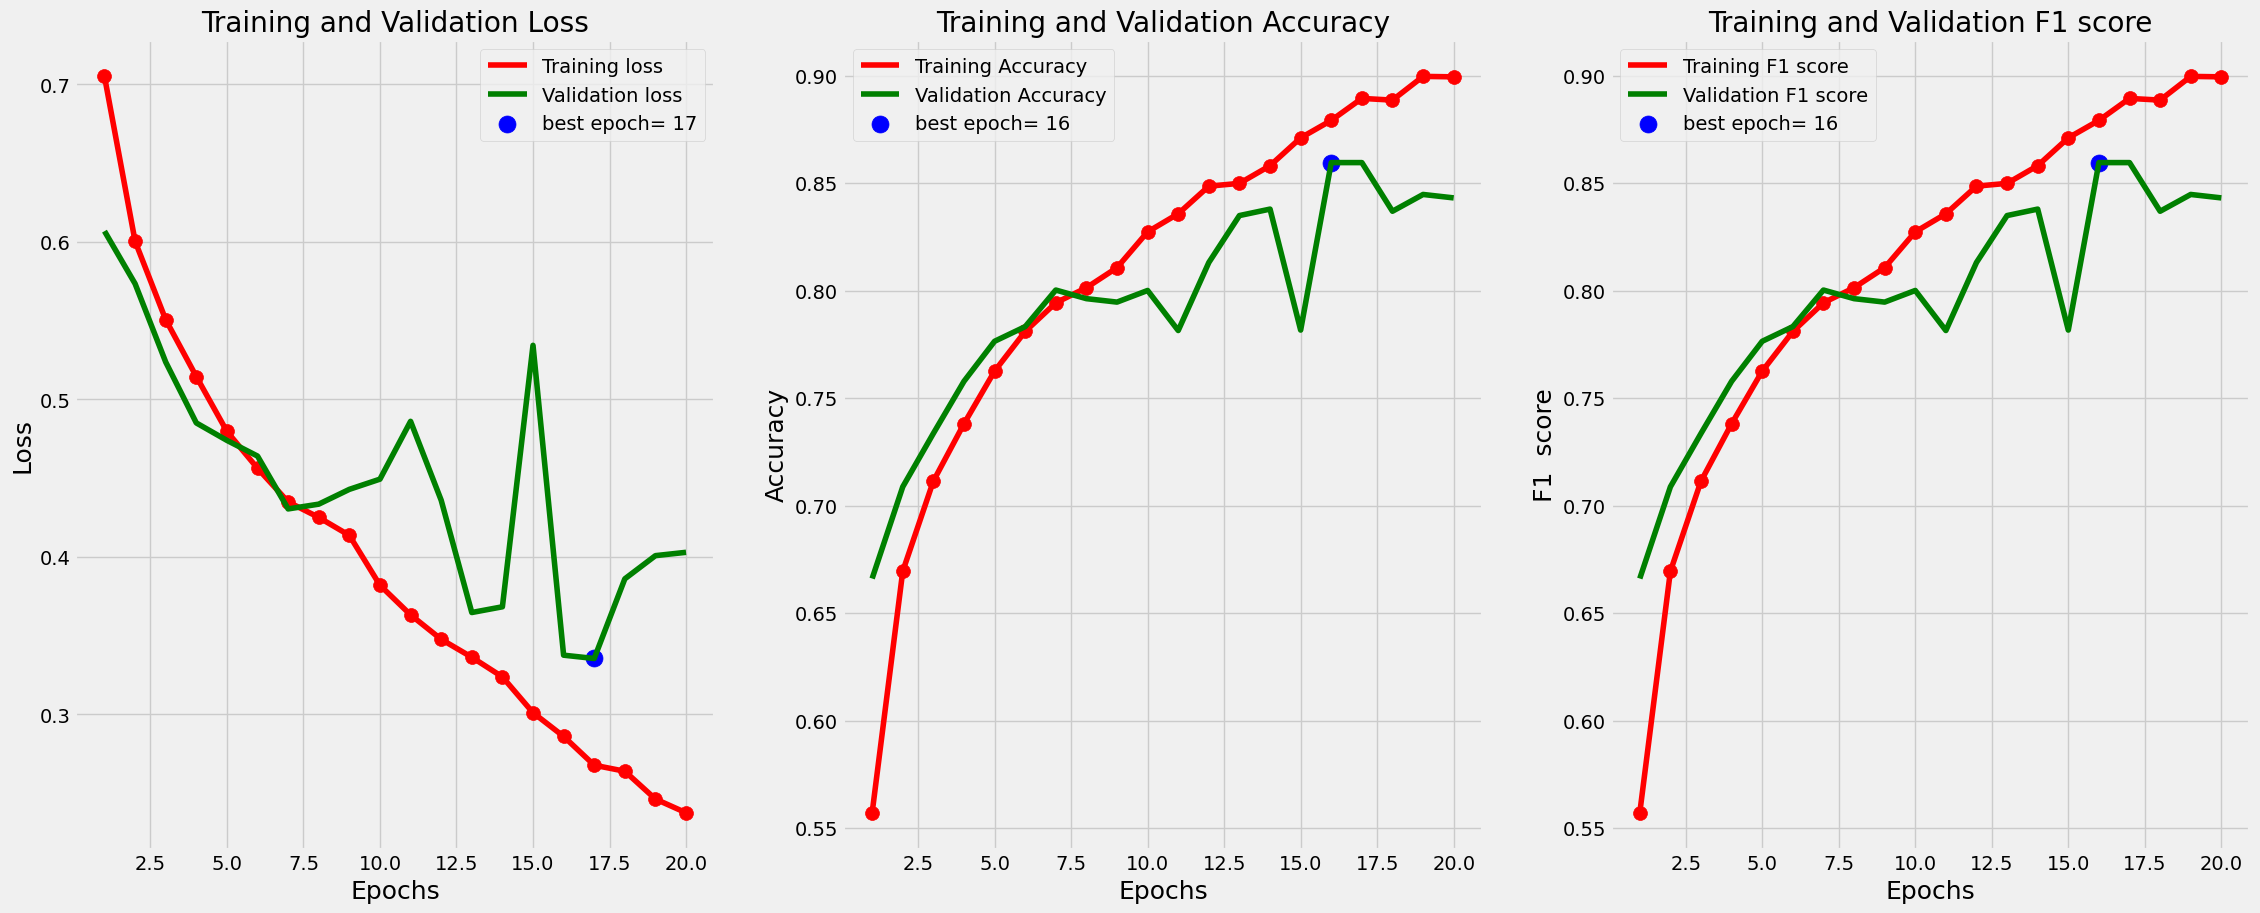

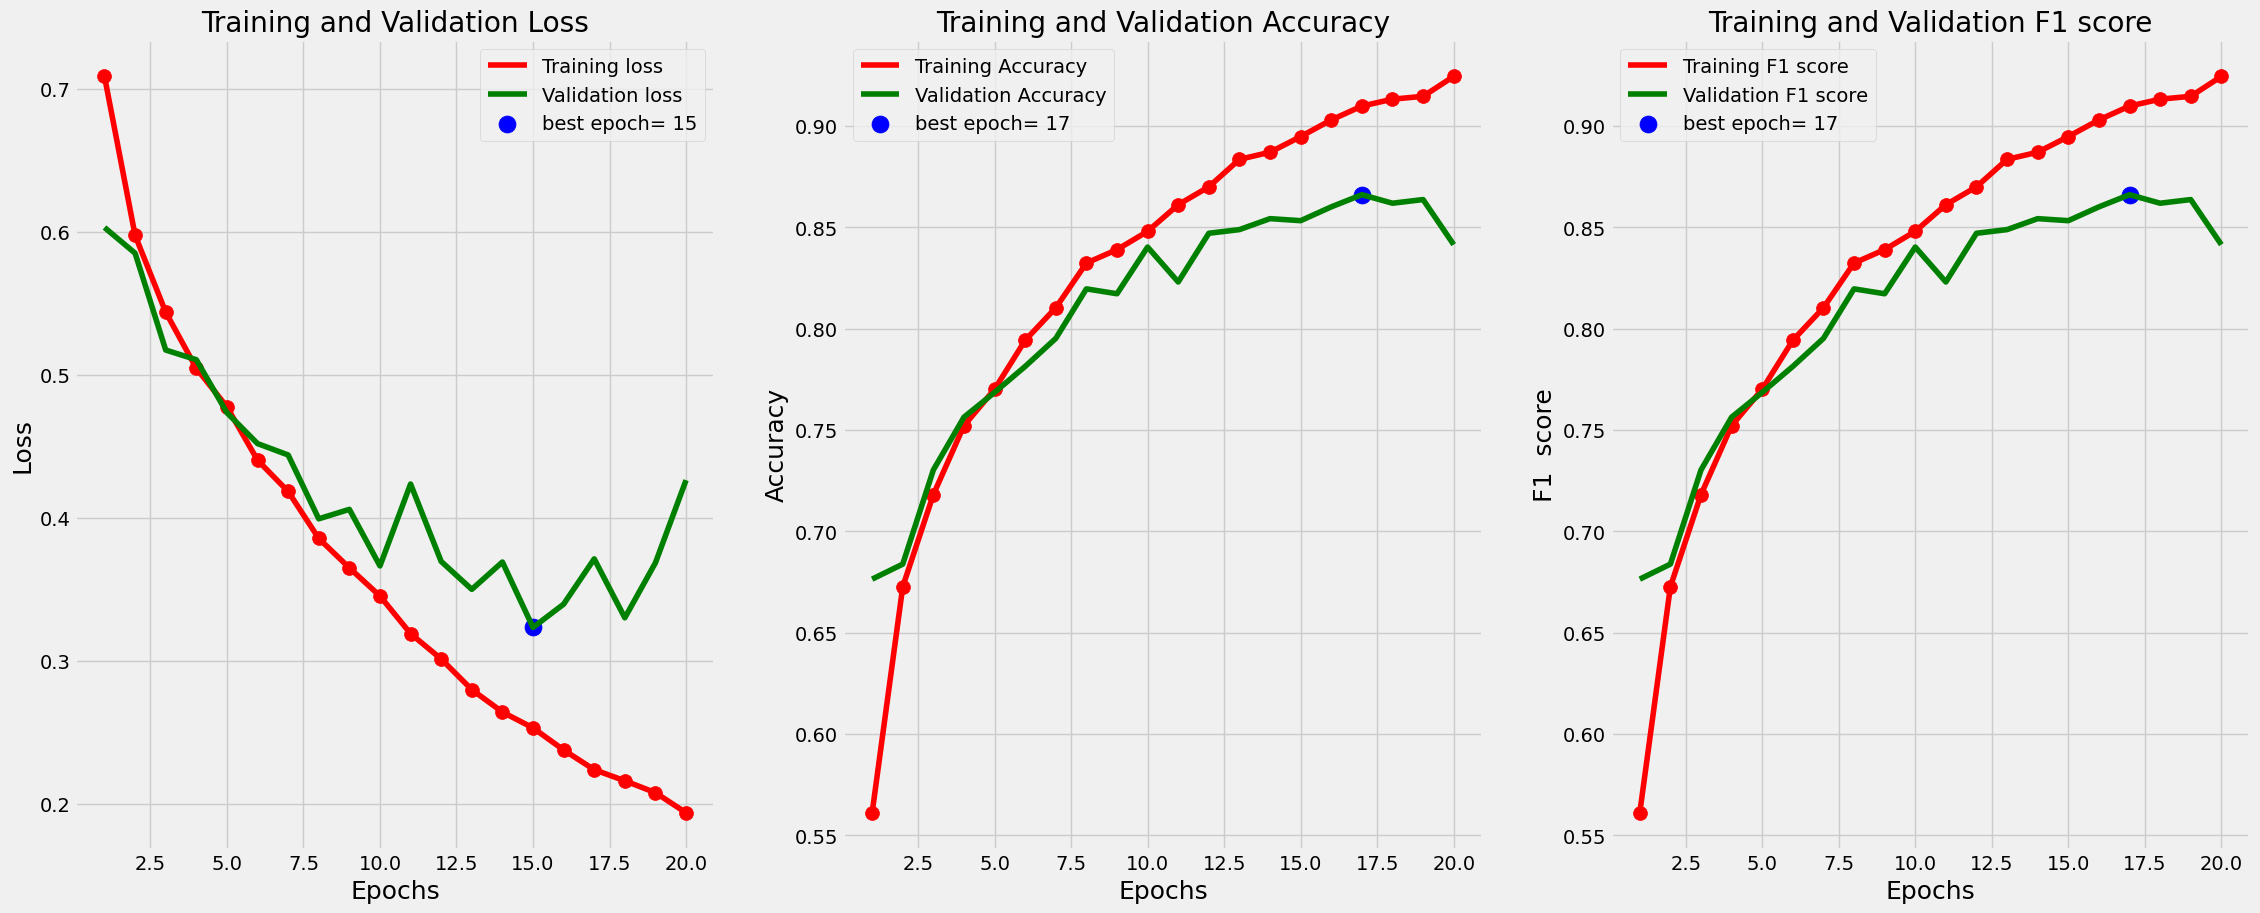

In [ ]:
for i in range(4):
    tr_plot(history[i])

In [ ]:
test_generator = datagen.flow_from_directory('cifake/test',
                                             target_size=(32, 32),
                                             batch_size=32,
                                             class_mode='categorical')

for i, model in enumerate(models):
    print("Model %d evaluation" %(i+1))
    test_loss, test_acc, test_f1_score = model.evaluate(test_generator, steps=len(test_generator))
    print('Test accuracy:', test_acc)
    print('Test loss:', test_loss)
    print('Test f1_score:', test_f1_score)

Found 4998 images belonging to 2 classes.
Model 1 evaluation
157/157 [==============================] - 9s 57ms/step - loss: 0.3257 - accuracy: 0.8741 - f1_score: 0.8741
Test accuracy: 0.8741496801376343
Test loss: 0.32574135065078735
Test f1_score: 0.8741496205329895
Model 2 evaluation
157/157 [==============================] - 13s 81ms/step - loss: 0.2862 - accuracy: 0.8882 - f1_score: 0.8882
Test accuracy: 0.8881552815437317
Test loss: 0.28615492582321167
Test f1_score: 0.8881552219390869
Model 3 evaluation
157/157 [==============================] - 2s 15ms/step - loss: 0.3847 - accuracy: 0.8511 - f1_score: 0.8511
Test accuracy: 0.8511404395103455
Test loss: 0.38466382026672363
Test f1_score: 0.8511403799057007
Model 4 evaluation
157/157 [==============================] - 3s 19ms/step - loss: 0.4246 - accuracy: 0.8505 - f1_score: 0.8505
Test accuracy: 0.8505402207374573
Test loss: 0.42456626892089844
Test f1_score: 0.8505401611328125


In [ ]:
positional_embedding_layer = model.layers[-2]
positional_embeddings = positional_embedding_layer.get_weights()[0]


# 선택한 위치에 대한 임베딩을 시각화합니다. 예를 들어, 첫번째 위치입니다.
position_to_visualize = 0
embedding_to_visualize = positional_embeddings[position_to_visualize]

plt.figure(figsize=(10, 10))
sns.heatmap(embedding_to_visualize.reshape((1, -1)), annot=True, cmap='viridis')
plt.show()


IndexError: list index out of range